# Modeling Crop Yield

In [1]:
import warnings
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import geopandas

import pyarrow
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from scipy.stats import spearmanr
from scipy.linalg import LinAlgWarning
from scipy.stats import pearsonr

import math
import seaborn as sns

## Parameters

In [2]:
# satellite = "landsat-8-c2-l2"
satellite = "sentinel-2-l2a"

bands = "2-3-4"
# bands = "2-3-4-8"
# bands = "1-2-3-4-5-6-7"

country_code = "ZMB"

# points = "4"
# points = "15"
points = "24"
# points = "42"

num_features = "1000"

feature_file_name = (f'{satellite}_bands-{bands}_{country_code}_{points}k-points_{num_features}-features')
weight_file_name = (f'{country_code}_crop_weights{points}k-points')

year_start = 2015
year_end = 2018

if points == "4":
    marker_sz = 60
elif points == "15":
    marker_sz = 20
elif points == "24":
    marker_sz = 10
else:
    marker_sz = 8

## Boundaries 

In [3]:
country_shp = geopandas.read_file(f'/capstone/cropmosaiks/data/boundaries/gadm36_{country_code}_2.shp')
country_shp = country_shp.rename(columns = {'NAME_2': 'district'})[['district', 'geometry']]
country_shp.district = country_shp.district.replace("MPongwe", 'Mpongwe', regex=True)
country_districts = country_shp.district.sort_values().unique().tolist()
country_shp = country_shp.set_index('district')
country_shp.shape
# country_shp.plot(column = 'district',linewidth = 1, edgecolor = 'black' )
# country_shp

(72, 1)

## Crops

In [4]:
crop_df = pd.read_csv('/capstone/cropmosaiks/data/crops/cfs_maize_districts_zambia_2009_2018.csv')
crop_df.district = crop_df.district.replace(
    {"Itezhi-tezhi": 'Itezhi-Tezhi',
     "Kapiri-Mposhi": 'Kapiri Mposhi',
     "Shang'ombo": 'Shangombo',
     "Chienge": 'Chiengi'
    }, regex=True)
crop_districts = crop_df.district.sort_values().unique().tolist()
crop_df = crop_df[['district', 'year', 'yield_mt']]
ln = len(crop_df[crop_df.year == 2016].district)
crop_df = crop_df.set_index('district')
ln
# crop_df

74

In [5]:
list(set(crop_districts) - set(country_districts))

['Ikelenge', 'Mafinga']

In [6]:
list(set(country_districts) - set(crop_districts))

[]

In [7]:
country_crop = geopandas.GeoDataFrame(crop_df.join(country_shp), crs = country_shp.crs)

## Weights

In [8]:
# weights = pd.read_feather(f"data/weights/{weight_file_name}_2018.feather")
# weights.crop_perc = weights.crop_perc.fillna(0)
# weights.crop_perc = weights.crop_perc + 0.0001
# weights

In [9]:
# weights_gdf.plot(figsize = (15,15),
                 # cmap = 'inferno',
                 # cmap = new_cmap,
                 # markersize = 3,
                 # alpha = .9,
                 # column = 'crop_perc')
# plt.axis('off')

## Features

In [10]:
features_raw = geopandas.GeoDataFrame()

for yr in range(year_start, year_end + 1):
    print(f"Opening: {feature_file_name}_{yr}.feather")
    features_x = pd.read_feather(f"/capstone/cropmosaiks/data/features/{feature_file_name}_{yr}.feather")
    
    # concatenate the feather files together, axis = 0 specifies to stack rows (rather than adding columns)
    features_raw = pd.concat([features_raw, features_x], axis=0)
    
    print("feature.shape", features_raw.shape)
    print("Appending:", yr)
    print("")

Opening: sentinel-2-l2a_bands-2-3-4_ZMB_24k-points_1000-features_2015.feather
feature.shape (34613, 1004)
Appending: 2015

Opening: sentinel-2-l2a_bands-2-3-4_ZMB_24k-points_1000-features_2016.feather
feature.shape (247217, 1004)
Appending: 2016

Opening: sentinel-2-l2a_bands-2-3-4_ZMB_24k-points_1000-features_2017.feather
feature.shape (429806, 1004)
Appending: 2017

Opening: sentinel-2-l2a_bands-2-3-4_ZMB_24k-points_1000-features_2018.feather
feature.shape (662779, 1004)
Appending: 2018



In [11]:
features = features_raw.copy()
if year_start == 2013:
    features = features[features.month > 6]
else:
    pass

features['year'] = np.where(
    features['month'].isin([7, 8, 9, 10, 11, 12]),
    features['year'] + 1, 
    features['year'])

features = features[features['year'] <= year_end]

features.sort_values(['year', 'month'], inplace=True)

In [12]:
features = features[features.month.isin([4, 5, 6])]

In [13]:
# Here we pivot the data from long format to wide by indexing on 
# 'lon','lat', "year", 'month' and using the unstack function
features = features.set_index(['lon','lat', "year", 'month']).unstack()

# We then map column names based on the month index and the associated features
# so month '01' is appended to each feature for that month making 0_01, 1_01 etc. 
features.columns = features.columns.map(lambda x: '{}_{}'.format(*x))

In [14]:
features.replace([np.inf, -np.inf], np.nan, inplace=True)

In [15]:
impute_data = True
# impute_data = False

if impute_data:
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit_transform(features)
    features[:] = imputer.transform(features)
    features = features.reset_index()
else:
    features = features.fillna(0)

In [16]:
features = geopandas.GeoDataFrame(
    features, 
    geometry = geopandas.points_from_xy(x = features.lon, y = features.lat)
    , crs='EPSG:4326'
)#.join(weights.set_index(['lon', 'lat']), on = ['lon', 'lat']) # Optionally attach weight to each point (% area cropped of surrounding 1 km^2)
# Drop lon and lat now that they are in geometry column
features = features.drop(['lon', 'lat'], axis = 1)

In [17]:
# mn = 9
# yr = 2017
# feature = 999

# features[features.year == yr].plot(
#     column = f"{feature}_{mn}",
#     figsize = (10,10),
#     marker='H',
#     # legend = True,
#     markersize = marker_sz,
# )

In [18]:
features = features.sjoin(country_shp, how = 'left', predicate = 'within')

In [19]:
# features

In [20]:
# na = features[adm_features.isna().any(axis = 1)]
# na.plot(figsize = (10,10), markersize = 10)

In [21]:
features = (
    features
    .dropna(subset=['index_right'])
    .rename(columns = {
        "index_right": "district", 
    })
    .reset_index(drop = True)
)
features_gdf = features.copy()
features = features.drop(['geometry'], axis = 1)

In [22]:
# features

In [23]:
features_summary = features.groupby(['district',"year"], as_index = False).mean()
# features_summary

In [24]:
crop_df_x = crop_df[crop_df.year >= year_start + 1]
crop_df_x = crop_df_x[~crop_df_x.index.isin(['Mafinga', 'Ikelenge'])]
crop_df_x.reset_index(inplace=True)
# crop_df_x

In [25]:
features_summary = features_summary.set_index(["district", "year"]).join(other = crop_df_x.set_index(["district", "year"])).reset_index()
# features_summary

In [26]:
# features_croppped = features[features.crop_perc > 0]
# features.shape

In [27]:
# features_summary = features.groupby(['district', 'yield_mt' ,"year"], as_index = False
#                                    ).apply(lambda x: np.average(x['0'], weights=x['crop_perc'], axis = 0))
# features_summary

## Model

In [28]:
x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

# y_all = features_summary.yield_mt
y_all = np.log10(features_summary.yield_mt.to_numpy() + 1)

In [29]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all, test_size=0.2, random_state=0
)

In [30]:
len(y_all)

216

In [31]:
len(x_train)

172

In [32]:
len(x_test)

44

In [33]:
ridge_cv_random = RidgeCV(cv=5, alphas=np.logspace(-8, 8, base=10, num=17))
ridge_cv_random.fit(x_train, y_train)

RidgeCV(alphas=array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08]),
        cv=5)

In [34]:
print(f"Validation R2 performance {ridge_cv_random.best_score_:0.2f}")

Validation R2 performance 0.35


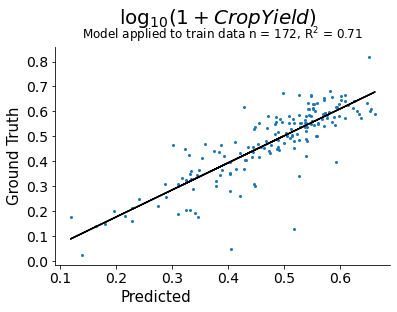

In [35]:
y_pred = np.maximum(ridge_cv_random.predict(x_train), 0)

plt.figure()
plt.scatter(y_pred, y_train, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15, x = .3)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title((f"Model applied to train data n = {len(x_train)}, R$^2$ = {(r2_score(y_train, y_pred)):0.2f}"),
          fontsize=12, y=1.01)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_train, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_train_data.jpg', dpi=300)
plt.show()
plt.close()

In [36]:
r2_score(y_train, y_pred)

0.7072973037011312

In [37]:
pearsonr(y_pred, y_train)

(0.8434759182063355, 9.496638623311855e-48)

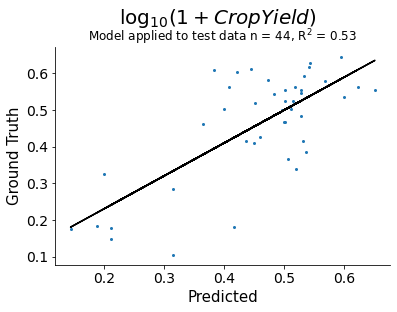

In [39]:
y_pred = np.maximum(ridge_cv_random.predict(x_test), 0)

plt.figure()
plt.scatter(y_pred, y_test, alpha=1, s=4)
plt.xlabel("Predicted", fontsize=15)
plt.ylabel("Ground Truth", fontsize=15)
plt.suptitle(r"$\log_{10}(1 + Crop Yield)$", fontsize=20, y=1.02)
plt.title(f"Model applied to test data n = {len(x_test)}, R$^2$ = {(r2_score(y_test, y_pred)):0.2f}",
          fontsize=12, y=1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

m, b = np.polyfit(y_pred, y_test, 1)
plt.plot(y_pred, m * y_pred + b, color="black")
plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

# plt.savefig(f'images/{feature_file_name}_test_data.jpg', dpi=300)
plt.show()
plt.close()

In [40]:
r2_score(y_test, y_pred)

0.5271294296337656

In [41]:
pearsonr(y_pred, y_test) 

(0.7315148007155546, 1.6966009975428445e-08)

In [43]:
pred_features = features.copy()
pred_features['geometry'] = features_gdf['geometry']
pred_features = geopandas.GeoDataFrame(pred_features)
x_all = pred_features.drop([
    'year', 
    'district',
    'geometry', 
#     'yield_mt'
                           ], axis = 1)
pred_features['fit'] = np.maximum(ridge_cv_random.predict(x_all), 0)

In [44]:
plot_features = pred_features[pred_features.year == 2018]
# plot_features

<AxesSubplot:>

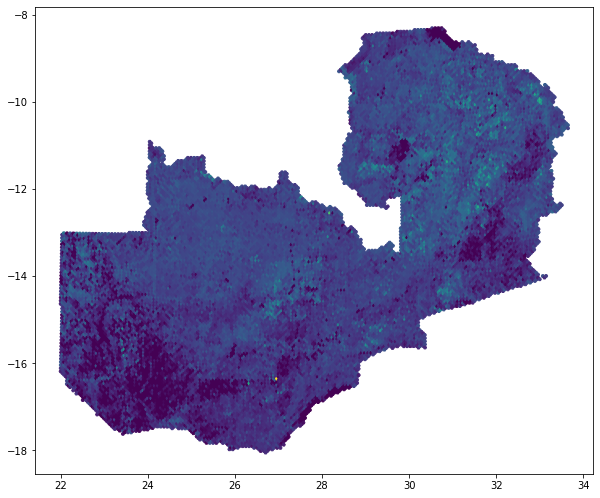

In [45]:
plot_features.plot(figsize = (10,10),
                   marker='H',
                   # legend = True,
                   markersize = marker_sz,
#                    alpha = .9,
                   column = 'fit')

## Plot Residuals

In [46]:
# yr = 2015
# features_summary = features_summary[features_summary.year == yr]

x_all = features_summary.drop([
    'district', 
    'year', 
    'yield_mt'], axis = 1)

residual_df = pd.DataFrame()

residual_df["yield"] = np.log10(features_summary.yield_mt.to_numpy() + 1)
residual_df["prediction"] = np.maximum(ridge_cv_random.predict(x_all), 0)
residual_df["residual"] = residual_df["yield"] - residual_df["prediction"]
residual_df["demean_yield"] = residual_df["yield"] - residual_df["yield"].mean()
residual_df["demean_prediction"] = residual_df["prediction"] - residual_df["prediction"].mean()
residual_df["year"] = features_summary.year
residual_df["district"] = features_summary.district
residual_df = residual_df.join(country_shp, how = "left", on = "district")
residual_gdf = geopandas.GeoDataFrame(residual_df)
residual_gdf

,yield,prediction,residual,demean_yield,demean_prediction,year,district,geometry
0,0.458853,0.489122,-0.030269,-0.014447,0.016648,2016,Chadiza,"POLYGON ((32.31720 -13.95683, 32.33500 -13.965..."
1,0.589161,0.569918,0.019243,0.115861,0.097444,2017,Chadiza,"POLYGON ((32.31720 -13.95683, 32.33500 -13.965..."
2,0.361592,0.334420,0.027172,-0.111708,-0.138054,2018,Chadiza,"POLYGON ((32.31720 -13.95683, 32.33500 -13.965..."
3,0.353619,0.404268,-0.050649,-0.119681,-0.068206,2016,Chama,"POLYGON ((33.27486 -11.43445, 33.27387 -11.434..."
4,0.519567,0.489791,0.029775,0.046266,0.017317,2017,Chama,"POLYGON ((33.27486 -11.43445, 33.27387 -11.434..."
...,...,...,...,...,...,...,...,...
211,0.341696,0.526961,-0.185265,-0.131604,0.054487,2017,Solwezi,"POLYGON ((27.21271 -11.58675, 27.22162 -11.624..."
212,0.452073,0.517451,-0.065377,-0.021227,0.044976,2018,Solwezi,"POLYGON ((27.21271 -11.58675, 27.22162 -11.624..."
213,0.435413,0.421065,0.014348,-0.037887,-0.051409,2016,Zambezi,"POLYGON ((23.66734 -13.98420, 23.66075 -13.991..."
214,0.396279,0.404024,-0.007745,-0.077021,-0.068450,2017,Zambezi,"POLYGON ((23.66734 -13.98420, 23.66075 -13.991..."


In [47]:
residual_sq = residual_gdf[residual_gdf.year == 2016].residual**2
ssr_2016 = sum(residual_sq)
ssr_2016

rse_2016 = math.sqrt(ssr_2016/len(residual_sq))
print("Residual Standard Error 2016:", rse_2016)

Residual Standard Error 2016: 0.08039780334250284


In [48]:
residual_sq = residual_gdf[residual_gdf.year == 2017].residual**2
ssr_2017 = sum(residual_sq)
ssr_2017

rse_2017 = math.sqrt(ssr_2017/len(residual_sq))
print("Residual Standard Error 2017:", rse_2017)

Residual Standard Error 2017: 0.08355083638019767


In [49]:
residual_sq = residual_gdf[residual_gdf.year == 2018].residual**2
ssr_2018 = sum(residual_sq)
ssr_2018

rse_2018 = math.sqrt(ssr_2018/len(residual_sq))
print("Residual Standard Error 2018:", rse_2018)

Residual Standard Error 2018: 0.08534380683645551


In [107]:
# true_yield_2018 = residual_gdf[residual_gdf.year == 2018]['yield']
# residual_2018 = residual_gdf[residual_gdf.year == 2018]['residual']

# plt.figure()

# p = sns.jointplot(x=true_yield_2018, y = residual_2018).set_axis_labels("True Yield", "Residuals")
# # p.axhline(0)
# plt.suptitle("Plot of Yield vs Residuals 2018",
#           fontsize=12, y=1)

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# plt.show()
# plt.close()

Text(0.5, 1.0, 'Plot of Yield vs Residuals 2018')

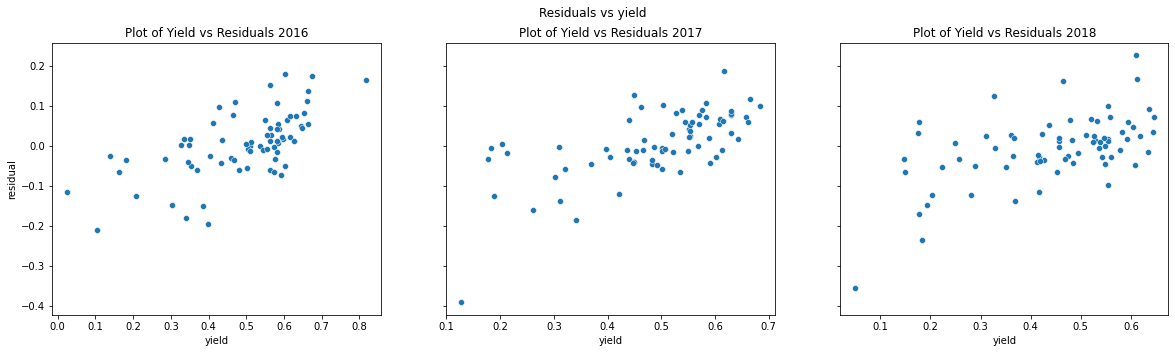

In [110]:
true_yield_2016 = residual_gdf[residual_gdf.year == 2016]['yield']
residual_2016 = residual_gdf[residual_gdf.year == 2016]['residual']

true_yield_2017 = residual_gdf[residual_gdf.year == 2017]['yield']
residual_2017 = residual_gdf[residual_gdf.year == 2017]['residual']

true_yield_2018 = residual_gdf[residual_gdf.year == 2018]['yield']
residual_2018 = residual_gdf[residual_gdf.year == 2018]['residual']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle('Residuals vs yield')

sns.scatterplot(ax=ax1, x=true_yield_2016, y = residual_2016)
ax1.set_title("Plot of Yield vs Residuals 2016")

sns.scatterplot(ax=ax2, x=true_yield_2017, y = residual_2017)
ax2.set_title("Plot of Yield vs Residuals 2017")

sns.scatterplot(ax=ax3, x=true_yield_2018, y = residual_2018)
ax3.set_title("Plot of Yield vs Residuals 2018")

# All Residual Plots

Text(0.5, 0.01, 'A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction')

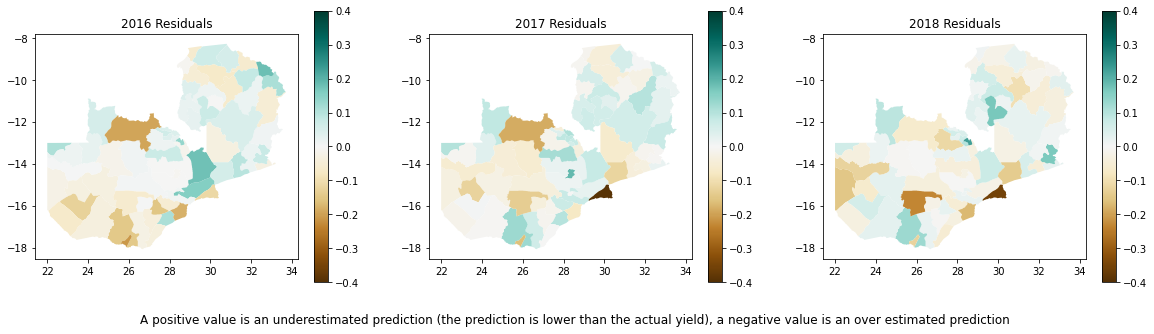

In [109]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1 = (residual_gdf[residual_gdf.year == 2016]
       .plot(ax = ax1, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2016 Residuals"))
ax2 = (residual_gdf[residual_gdf.year == 2017]
       .plot(ax = ax2, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2017 Residuals"))
ax3 = (residual_gdf[residual_gdf.year == 2018]
       .plot(ax = ax3, column = "residual", legend = True, norm=colors.Normalize(vmin= -0.4, vmax=0.4), cmap = "BrBG")
       .set_title("2018 Residuals"))

caption = "A positive value is an underestimated prediction (the prediction is lower than the actual yield), a negative value is an over estimated prediction"
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)

Text(0.5, 1.0, '2018 Residuals')

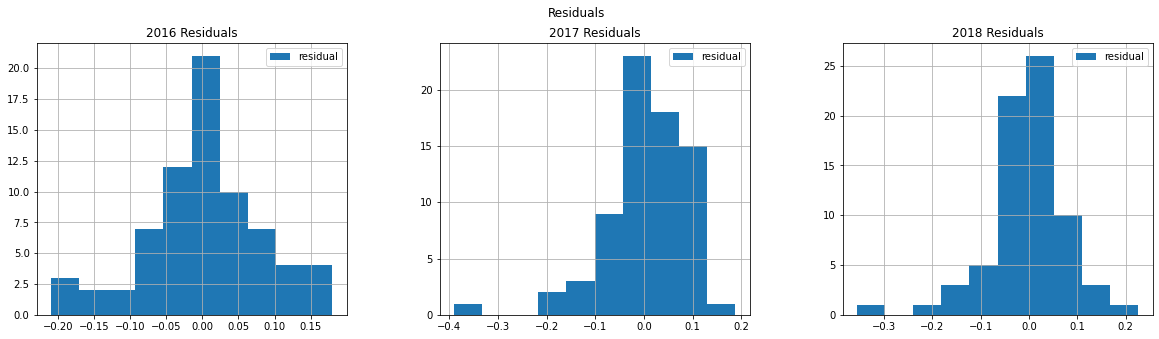

In [111]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
plt.suptitle("Residuals")
plt.ax1 = residual_gdf[residual_gdf.year == 2016].hist(ax = ax1, column = "residual", legend = True)
ax1.set_title("2016 Residuals")
plt.ax2 = residual_gdf[residual_gdf.year == 2017].hist(ax = ax2, column = "residual", legend = True) 
ax2.set_title("2017 Residuals")
plt.ax3 = residual_gdf[residual_gdf.year == 2018].hist(ax = ax3, column = "residual", legend = True)
ax3.set_title("2018 Residuals")

In [58]:
residual_gdf.residual.min()

-0.39111541632095564

In [59]:
residual_gdf.residual.max()

0.22638641001377457

# Difference from the Mean

In [60]:
residual_gdf_2016 = residual_gdf[residual_gdf.year == 2016]
residual_gdf_2017 = residual_gdf[residual_gdf.year == 2017]
residual_gdf_2018 = residual_gdf[residual_gdf.year == 2018]

Text(0, 0.5, 'Difference from Predictions Mean')

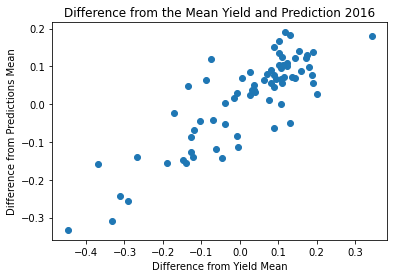

In [61]:
plt.scatter(residual_gdf_2016["demean_yield"], residual_gdf_2016["demean_prediction"])
plt.title("Difference from the Mean Yield and Prediction 2016")
plt.xlabel("Difference from Yield Mean")
plt.ylabel("Difference from Predictions Mean")

Text(0, 0.5, 'Difference from Predictions Mean')

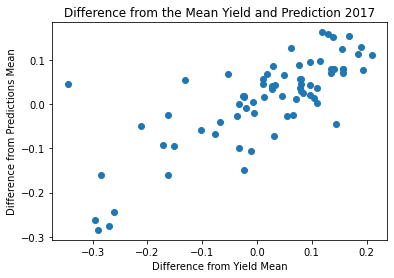

In [62]:
plt.scatter(residual_gdf_2017["demean_yield"], residual_gdf_2017["demean_prediction"])
plt.title("Difference from the Mean Yield and Prediction 2017")
plt.xlabel("Difference from Yield Mean")
plt.ylabel("Difference from Predictions Mean")

Text(0, 0.5, 'Difference from Predictions Mean')

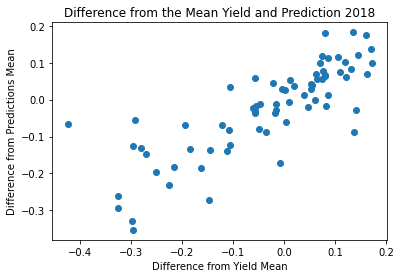

In [63]:
plt.scatter(residual_gdf_2018["demean_yield"], residual_gdf_2018["demean_prediction"])
plt.title("Difference from the Mean Yield and Prediction 2018")
plt.xlabel("Difference from Yield Mean")
plt.ylabel("Difference from Predictions Mean")

Text(0, 0.5, 'Difference from Predictions Mean')

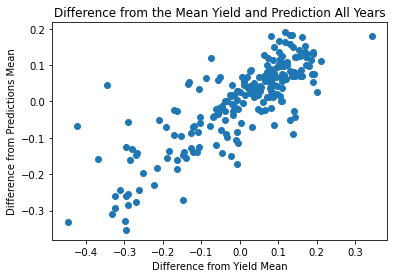

In [64]:
# all years
plt.scatter(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
plt.title("Difference from the Mean Yield and Prediction All Years")
plt.xlabel("Difference from Yield Mean")
plt.ylabel("Difference from Predictions Mean")

Text(0, 0.5, 'y axis')

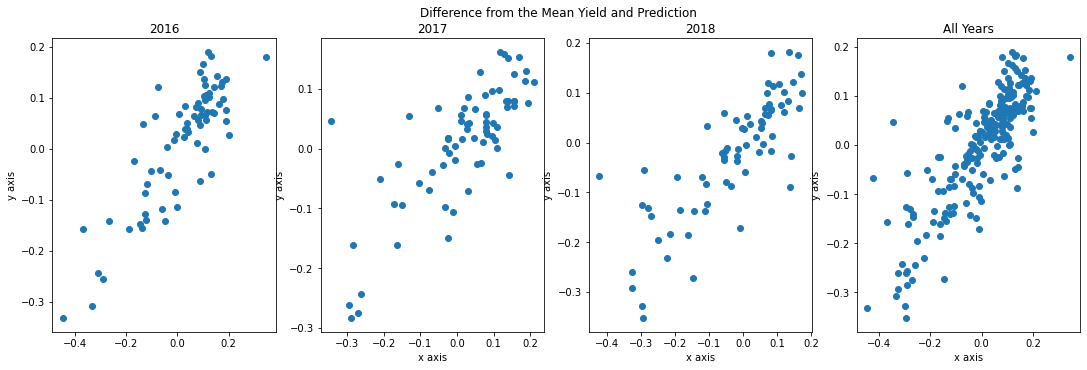

In [113]:
x1 = residual_gdf_2016["demean_yield"]
y1 = residual_gdf_2016["demean_prediction"]

x2 = residual_gdf_2017["demean_yield"]
y2 = residual_gdf_2017["demean_prediction"]

x3 = residual_gdf_2018["demean_yield"]
y3 = residual_gdf_2018["demean_prediction"]

x4 = residual_gdf["demean_yield"]
y4 = residual_gdf["demean_prediction"]

plt.subplots(figsize = (15, 5))
plt.suptitle("Difference from the Mean Yield and Prediction")
plt.tight_layout()

plt.subplot(1, 4, 1)
plt.scatter(x1, y1)
plt.title('2016')
plt.ylabel('y axis')

plt.subplot(1, 4, 2)
plt.scatter(x2, y2)
plt.title("2017")
plt.xlabel('Difference from Yield Mean')
plt.ylabel('Difference from Predictions Mean')

plt.subplot(1, 4, 3)
plt.scatter(x3, y3)
plt.title("2018")
plt.xlabel('x axis')
plt.ylabel('Difference from Predictions Mean')

plt.subplot(1, 4, 4)
plt.scatter(x4, y4)
plt.title("All Years")
plt.xlabel('x axis')
plt.ylabel('Difference from Predictions Mean')

In [66]:
r_squared_2016 = r2_score(residual_gdf_2016["demean_yield"], residual_gdf_2016["demean_prediction"])
print("2016 R^2: ", r_squared_2016)
pearsonr_2016 = pearsonr(residual_gdf_2016["demean_yield"], residual_gdf_2016["demean_prediction"])
print("2016 Pearson's: ", pearsonr_2016[0])
print("")

r_squared_2017 = r2_score(residual_gdf_2017["demean_yield"], residual_gdf_2017["demean_prediction"])
print("2017 R^2: ", r_squared_2017)
pearsonr_2017 = pearsonr(residual_gdf_2017["demean_yield"], residual_gdf_2017["demean_prediction"])
print("2017 Pearson's: ", pearsonr_2017[0])
print("")

r_squared_2018 = r2_score(residual_gdf_2018["demean_yield"], residual_gdf_2018["demean_prediction"])
print("2018 R^2: ", r_squared_2018)
pearsonr_2018 = pearsonr(residual_gdf_2018["demean_yield"], residual_gdf_2018["demean_prediction"])
print("2018 Pearson's: ", pearsonr_2018[0])
print("")

r_squared_allyrs = r2_score(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print("All Years R^2: ", r_squared_allyrs)
pearsonr_allyrs = pearsonr(residual_gdf["demean_yield"], residual_gdf["demean_prediction"])
print("All Years Pearson's: ", pearsonr_allyrs[0])

2016 R^2:  0.7159848392171464
2016 Pearson's:  0.8492246410431469

2017 R^2:  0.5974237515856003
2017 Pearson's:  0.7740059994825381

2018 R^2:  0.659804397993205
2018 Pearson's:  0.8139396112944687

All Years R^2:  0.6713133459670492
All Years Pearson's:  0.819962444971333
